# An RNN model to generate sequences
RNN models can generate long sequences based on past data. This can be used to predict stock markets, temperatures, traffic or sales data based on past patterns. They can also be adapted to [generate text](https://docs.google.com/presentation/d/18MiZndRCOxB7g-TcCl2EZOElS5udVaCuxnGznLnmOlE/pub?slide=id.g139650d17f_0_1185). The quality of the prediction will depend on training data, network architecture, hyperparameters, the distance in time at which you are predicting and so on. But most importantly, it will depend on wether your training data contains examples of the behaviour patterns you are trying to predict.

<div class="alert alert-block alert-warning">
This is the solution file. The corresponding tutorial file is [01_RNN_generator_playground.ipynb](01_RNN_generator_playground.ipynb)
</div>

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import utils_prettystyle
import utils_batching
import utils_display
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.7.0


## Generate fake dataset

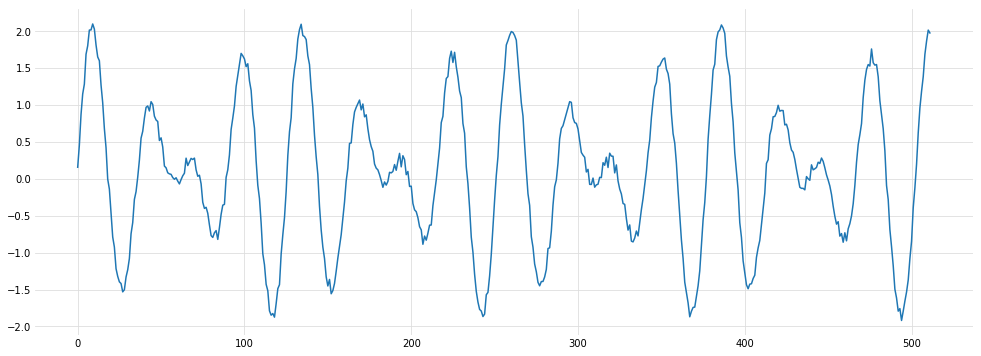

In [2]:
WAVEFORM_SELECT = 0 # select 0, 1 or 2

def create_time_series(datalen):
    # good waveforms
    frequencies = [(0.2, 0.15), (0.35, 0.3), (0.6, 0.55)]
    freq1, freq2 = frequencies[WAVEFORM_SELECT]
    noise = [np.random.random()*0.1 for i in range(datalen)]
    x1 = np.sin(np.arange(0,datalen) * freq1)  + noise
    x2 = np.sin(np.arange(0,datalen) * freq2)  + noise
    x = x1 + x2
    return x.astype(np.float32)

DATA_SEQ_LEN = 1024*128
data = create_time_series(DATA_SEQ_LEN)
plt.plot(data[:512])
plt.show()

## Hyperparameters

In [3]:
NB_EPOCHS = 10

RNN_CELLSIZE = 80   # size of the RNN cells
N_LAYERS = 2        # number of stacked RNN cells (needed for tensor shapes but code must be changed manually)
SEQLEN = 32         # unrolled sequence length
BATCHSIZE = 32      # mini-batch size
DROPOUT_PKEEP = 0.7 # dropout: probability of neurons being kept (NOT dropped). Should be between 0.5 and 1.

## Visualize training sequences
This is what the neural network will see during training.

Features shape: (32, 32)
Labels shape: (32, 32)
Excerpt from first batch:


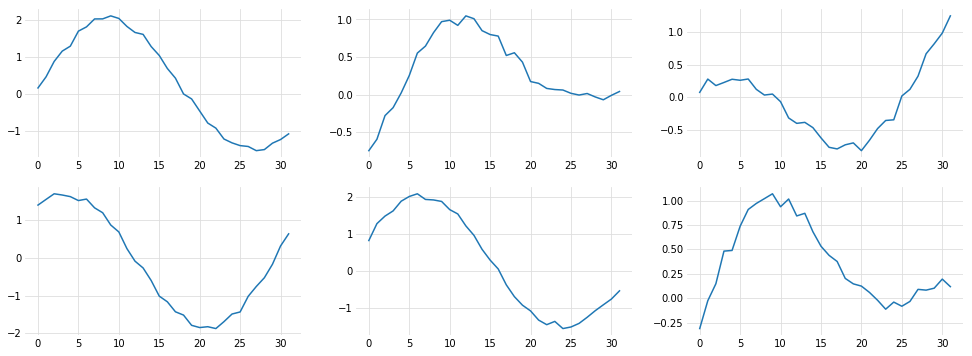

In [4]:
# The function dumb_minibatch_sequencer splits the data into batches of sequences sequentially.
for features, labels, epoch in utils_batching.dumb_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=1):
    break
print("Features shape: " + str(features.shape))
print("Labels shape: " + str(labels.shape))
print("Excerpt from first batch:")

utils_display.picture_this_7(features)

## The model definition
![deep RNN schematic](images/RNN1.svg)
<div style="text-align: right; font-family: monospace">
  X shape [BATCHSIZE, SEQLEN, 1]<br/>
  Y shape [BATCHSIZE, SEQLEN, 1]<br/>
  H shape [BATCHSIZE, RNN_CELLSIZE*NLAYERS]
</div>
When executed, this function instantiates the Tensorflow graph for our model.

In [5]:
def model_rnn_fn(features, Hin, labels, step, dropout_pkeep):
    X = features
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
    
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(N_LAYERS)]
    
    # add dropout between the cell layers
    cells[:-1] = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob = dropout_pkeep) for cell in cells[:-1]]
    # but no dropout after last cell layer: a small (80->1) regresion layer does not like its inputs being dropped.
    
    # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)
    # X[BATCHSIZE, SEQLEN, 1], Hin[BATCHSIZE, RNN_CELLSIZE*N_LAYERS]
    # the sequence unrolling happens here
    Yn, H = tf.nn.dynamic_rnn(cell, X, initial_state=Hin)
    # Yn[BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    Yn = tf.reshape(Yn, [batchsize*seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1) # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1]) # Yr [BATCHSIZE, SEQLEN, 1]
    Yout = Yr[:,-1,:] # Last output Yout [BATCHSIZE, 1]
    
    loss = tf.losses.mean_squared_error(Yr, labels) # labels[BATCHSIZE, SEQLEN, 1]
    lr = 0.001 + tf.train.exponential_decay(0.01, step, 400, 0.5) # 0.001+0.01*0.5^(step/400)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    train_op = optimizer.minimize(loss)
    
    return Yout, H, loss, train_op

## Instantiate the model

In [6]:
tf.reset_default_graph() # restart model graph from scratch

# placeholder for inputs
Hin = tf.placeholder(tf.float32, [None, RNN_CELLSIZE * N_LAYERS])
features = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
labels = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
step = tf.placeholder(tf.int32)
dropout_pkeep = tf.placeholder(tf.float32)

# instantiate the model
Yout, H, loss, train_op = model_rnn_fn(features, Hin, labels, step, dropout_pkeep)

## Inference
This is a generative model: run one trained RNN cell in a loop

In [7]:
def prediction_run(prime_data, run_length):
    H_ = np.zeros([1, RNN_CELLSIZE * N_LAYERS]) # zero state initially
    Yout_ = np.zeros([1, 1])
    data_len = prime_data.shape[0]

    # prime the state from data
    if data_len > 0:
        Yin = np.array(prime_data)
        Yin = np.reshape(Yin, [1, data_len, 1]) # reshape as one sequence
        feed = {Hin: H_, features: Yin, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
    
    # run prediction
    # To generate a sequence, run a trained cell in a loop passing as input and input state
    # respectively the output and output state from the previous iteration.
    results = []
    for i in range(run_length):
        Yout_ = np.reshape(Yout_, [1, 1, 1]) # batch of a single sequence of a single vector with one element
        feed = {Hin: H_, features: Yout_, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
        results.append(Yout_[0,0])
        
    return np.array(results)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [8]:
# first input state
Hzero = np.zeros([BATCHSIZE, RNN_CELLSIZE * N_LAYERS])
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run([init])

[None]

## The training loop
You can re-execute this cell to continue training

In [9]:
H_ = Hzero
losses = []
indices = []
for i, (next_features, next_labels, epoch) in enumerate(utils_batching.rnn_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=NB_EPOCHS)):
    next_features = np.expand_dims(next_features, axis=2) # model wants 3D inputs [BATCHSIZE, SEQLEN, 1] 
    next_labels = np.expand_dims(next_labels, axis=2)

    feed = {Hin: H_, features: next_features, labels: next_labels, step: i, dropout_pkeep: DROPOUT_PKEEP}
    Yout_, H_, loss_, _ = sess.run([Yout, H, loss, train_op], feed_dict=feed)
    # print progress
    if i%100 == 0:
        print("epoch " + str(epoch) + ", batch " + str(i) + ", loss=" + str(np.mean(loss_)))
    if i%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(i)

epoch 0, batch 0, loss=0.90330845
epoch 0, batch 100, loss=0.00975888
epoch 1, batch 200, loss=0.012633373
epoch 2, batch 300, loss=0.008035592
epoch 3, batch 400, loss=0.008730125
epoch 3, batch 500, loss=0.006773348
epoch 4, batch 600, loss=0.0063604135
epoch 5, batch 700, loss=0.0061197067
epoch 6, batch 800, loss=0.005554078
epoch 7, batch 900, loss=0.005412671
epoch 7, batch 1000, loss=0.0074357227
epoch 8, batch 1100, loss=0.0050933966
epoch 9, batch 1200, loss=0.004718122


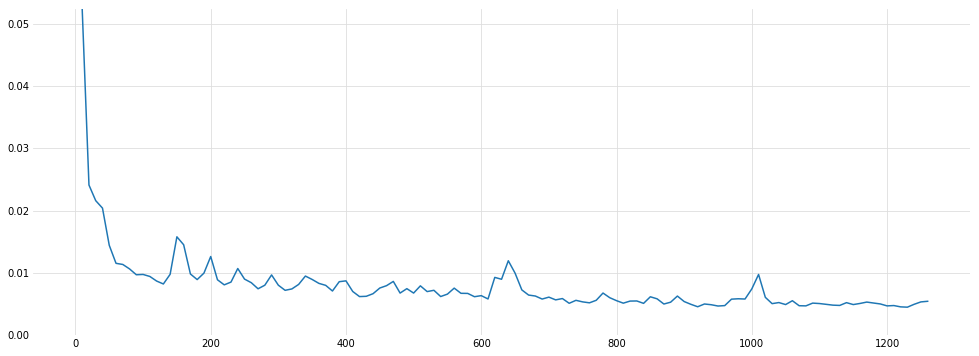

In [10]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value for scaling
plt.plot(indices, losses)
plt.show()

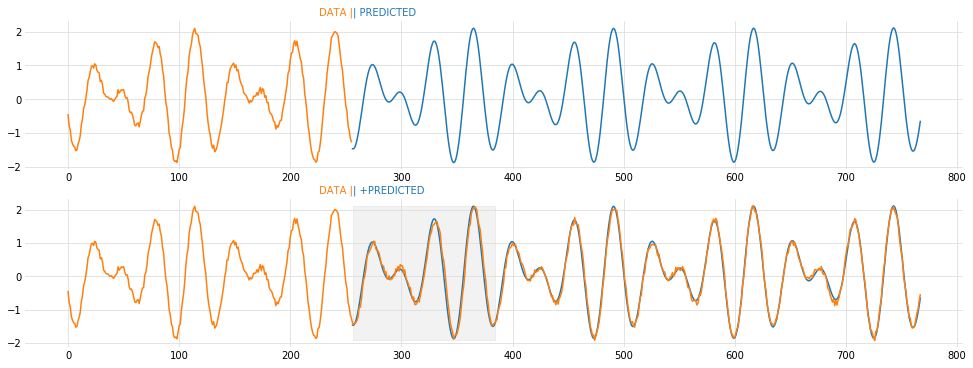

RMSE on 128 predictions (shaded area): 0.18484816250085143


In [11]:
PRIMELEN=256
RUNLEN=512
OFFSET=20
RMSELEN=128

prime_data = data[OFFSET:OFFSET+PRIMELEN]
results = prediction_run(prime_data, RUNLEN)

utils_display.picture_this_8(data, prime_data, results, OFFSET, PRIMELEN, RUNLEN, RMSELEN)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.